In [5]:
import sys
from pathlib import Path
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

In [15]:
from dreamingnetz._1d_ladder_helpers import SysConfig_1d, TrialConfig_1d , pool_orchestrator_stats_1d
from dreamingnetz.beta_ladder_search_1d import ladder_search_parallel

In [8]:
N = 700
α = 0.04

P = int(α*N)

In [ ]:
betas0 = np.geomspace(0.3, 9, 15)
sys0  = SysConfig_1d(N=N, P=P, K=betas0.size, t=0.5,c=0, β=betas0,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial1 = TrialConfig_1d(equilibration_time=6000, sweeps_per_sample=10, n_samples=500)

betas1, acc_stack1, I_ts_stack1 = ladder_search_parallel(
    sys_template=sys0, beta_init=betas0,
    trial=trial1, R_workers=10, R_total=10,

    A_low=0.15, A_high=0.48, A_star=0.36,
    q_lo=0.14,                 # fix 
    redistribute_every=2,      # number of inserts after which a reshape triggers in the next pass, this triggers very rarely
    low_max_for_reshape = 4,   # max number of lows to still trigger a reshape before the inserts can trigger
    n_hot = 0,                 # number of high T interfaces that ignore the high mask
    max_insert = 3,            # max number of inserts allowed between reshapes

    gamma_reshape=0.5,clip_reshape=(0.75, 1.35), # reshape strength and constraints on the stretching of Δβ_k

    K_max=45, max_passes=10, verbose=True, start_method = "fork"
)

 
 
pass  1 | K=15 | 
 
acc_trig=[75 65 48 24  3  0  0  0  2 10 30 49 64 88]
 
acc_low= [75 65 48 23  3  0  0  0  2 10 24 33 48 46]
 
＋ insert after iface 4
＋ insert after iface 5
＋ insert after iface 6
 
 
pass  2 | K=18 | 
 
acc_trig=[76 65 48 23 32 24 11 13  7  1  0  2 11 35 69 88 95]
 
acc_low= [75 65 48 23 31 22 10 13  6  0  0  1 11 32 55 71 84]
 
↺ reshape (fixed K)
 
 
pass  3 | K=18 | 
 
acc_trig=[70 56 43 32 39 36 28 26 20 23  0  1  3  6 19 62 81]
 
acc_low= [70 56 43 32 38 35 27 25 19 22  0  0  3  5 17 52 48]
 
＋ insert after iface 10
＋ insert after iface 11
＋ insert after iface 12
 
 
pass  4 | K=21 | 
 
acc_trig=[70 56 44 32 38 36 27 26 20 22  2 10 12 22 23 36  7 28 80 97]
 
acc_low= [70 56 43 32 38 35 26 25 19 22  1  7 11 22 22 35  7 27 63 85]
 
↺ reshape (fixed K)
 
 
pass  5 | K=21 | 
 
acc_trig=[63 50 42 38 42 42 38 36 30 33 30 15  8 17 17 22  4  6 45 94]
 
acc_low= [63 49 42 37 42 41 37 35 30 32 28 12  4 17 16 21  4  6 38 89]
 
＋ insert after iface 12
＋ insert after if

In [10]:
def pt_diagnostics_report(
    I_ts_stack,
    betas=None,
    acc_stack=None,
    *,
    q_lo=0.20,                  # disorder-guard quantile for acceptance summaries
    burn_in=0,                  # int steps, or float fraction in (0,1)
    chains=(0, 1),              # which independent chains to analyze (if present)
    plot_disorders=10,           # how many representative disorders to plot as lines
    trace_walkers=6,            # how many walkers to show in k_w(t) traces
    trace_disorder="worst",     # "worst" | "median" | int disorder index
    trace_chain=0,
    save_prefix=None,           # e.g. "diag_" -> saves diag_*.png
    show=True,
):
    """
    Drop-in PT diagnostics from I_ts (slot->walker time series) and optional acc_stack.

    Expected shapes:
      - I_ts_stack: (R, B, T, K) or (B, T, K) or (T, K)
      - acc_stack : (R, K-1) or (K-1,) (optional)

    Returns a dict of computed metrics (arrays are numpy).
    Produces plots (matplotlib) unless show=False.
    """


    # ---------- normalize input shapes ----------
    I = np.asarray(I_ts_stack)
    if I.ndim == 4:
        R, B, T, K = I.shape
    elif I.ndim == 3:
        R = 1
        B, T, K = I.shape
        I = I[None, ...]
    elif I.ndim == 2:
        R = 1
        B = 1
        T, K = I.shape
        I = I[None, None, ...]
    else:
        raise ValueError("I_ts_stack must have shape (R,B,T,K), (B,T,K), or (T,K).")

    if betas is None:
        beta = None
    else:
        beta = np.asarray(betas, float)
        if beta.shape[0] != K:
            raise ValueError(f"betas length {beta.shape[0]} does not match K={K}.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0

    temperatures = np.sort(1/np.asarray(betas))


    # chains to analyze
    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < B):
            raise ValueError(f"chain index {c} out of range for B={B}.")

    hot_k, cold_k = 0, K - 1

    # ---------- helpers ----------
    def _roundtrips_from_ends(w_hot, w_cold, K):
        """
        Hot-based round trips: hot->cold->hot for each walker.
        Returns (rt_times list, n_rt, rt_rate).
        """
        t_hot_start = np.full(K, -1, dtype=np.int64)
        seen_cold   = np.zeros(K, dtype=np.bool_)
        rts = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold visit marks success-in-between if a hot-start exists
            if t_hot_start[wc] != -1:
                seen_cold[wc] = True

            # hot visit closes a round trip if cold was seen
            if t_hot_start[wh] != -1 and seen_cold[wh]:
                rts.append(t - t_hot_start[wh])

            # (re)start from hot
            t_hot_start[wh] = t
            seen_cold[wh] = False

        n_rt = len(rts)
        rt_rate = n_rt / max(1, w_hot.shape[0])
        return rts, n_rt, rt_rate

    def _passages_from_ends(w_hot, w_cold, K):
        """
        One-way end-to-end passage times:
          - hot->cold and cold->hot, using "last end visited" timestamps per walker.
        Returns two lists: tau_hc, tau_ch.
        """
        last_end = np.zeros(K, dtype=np.int8)     # 0 none, +1 hot, -1 cold
        last_t   = np.full(K, -1, dtype=np.int64)

        tau_hc = []
        tau_ch = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold hit
            if last_end[wc] == +1:
                tau_hc.append(t - last_t[wc])
            last_end[wc] = -1
            last_t[wc] = t

            # hot hit
            if last_end[wh] == -1:
                tau_ch.append(t - last_t[wh])
            last_end[wh] = +1
            last_t[wh] = t

        return tau_hc, tau_ch

    def _flow_profile_f(I_bt):
        """
        Directional flow profile f(k) from one chain:
        I_bt: (Teff, K) slot->walker.
        Implements:
          label walker by last end visited: +1 (hot), -1 (cold), 0 unknown.
          f(k) = P(label=+1 | at slot k), estimated over time, excluding unknown labels.
        Returns:
          f: (K,) with NaNs possible if denom=0 at a slot (unlikely)
          denom: (K,) number of labeled samples accumulated at each slot
        """
        labels = np.zeros(K, dtype=np.int8)  # per walker: 0 unknown, +1 hot, -1 cold
        num = np.zeros(K, dtype=np.float64)
        den = np.zeros(K, dtype=np.float64)

        for t in range(I_bt.shape[0]):
            wh = int(I_bt[t, hot_k])
            wc = int(I_bt[t, cold_k])
            labels[wh] = +1
            labels[wc] = -1

            lab_slots = labels[I_bt[t]]  # (K,)
            known = (lab_slots != 0)
            den[known] += 1.0
            num[known] += (lab_slots[known] == +1)

        f = np.full(K, np.nan, dtype=np.float64)
        mask = den > 0
        f[mask] = num[mask] / den[mask]
        return f, den

    def _invert_perm(I_t):
        """Given I_t (K,) slot->walker, return k_of_w (K,) walker->slot."""
        k_of_w = np.empty(K, dtype=np.int16)
        k_of_w[I_t.astype(np.int64)] = np.arange(K, dtype=np.int16)
        return k_of_w

    def _backtracking_rho1(I_bt, walkers=None):
        """
        Backtracking correlation rho1 = Corr(delta k(t), delta k(t+1)) for selected walkers,
        where k_w(t) is walker position (slot index).
        Returns:
          rho_w: (len(walkers),) rho1 per walker (NaN if too few moves)
          rho_med: median rho1 ignoring NaNs
        """
        Te = I_bt.shape[0]
        if walkers is None:
            walkers = np.arange(K, dtype=np.int64)
        else:
            walkers = np.asarray(walkers, dtype=np.int64)

        # build k_w(t) for selected walkers only, streaming
        k_prev = _invert_perm(I_bt[0])[walkers].astype(np.int16)
        dk_prev = None
        xs = [[] for _ in range(walkers.size)]
        ys = [[] for _ in range(walkers.size)]

        for t in range(1, Te):
            k_now = _invert_perm(I_bt[t])[walkers].astype(np.int16)
            dk = (k_now - k_prev).astype(np.int16)
            if dk_prev is not None:
                for i in range(walkers.size):
                    xs[i].append(int(dk_prev[i]))
                    ys[i].append(int(dk[i]))
            dk_prev = dk
            k_prev = k_now

        rho = np.full(walkers.size, np.nan, dtype=np.float64)
        for i in range(walkers.size):
            x = np.array(xs[i], dtype=np.float64)
            y = np.array(ys[i], dtype=np.float64)
            if x.size >= 10 and np.std(x) > 0 and np.std(y) > 0:
                rho[i] = np.corrcoef(x, y)[0, 1]
        rho_med = np.nanmedian(rho)
        return rho, rho_med

    # ---------- compute per-disorder, per-chain metrics ----------
    rt_count = np.zeros((R, B), dtype=np.int64)
    rt_rate  = np.zeros((R, B), dtype=np.float64)
    rt_med   = np.full((R, B), np.nan, dtype=np.float64)

    tau_hc_med = np.full((R, B), np.nan, dtype=np.float64)
    tau_ch_med = np.full((R, B), np.nan, dtype=np.float64)

    f_prof = np.full((R, B, K), np.nan, dtype=np.float64)
    f_slope_max = np.full((R, B), np.nan, dtype=np.float64)

    rho1_med = np.full((R, B), np.nan, dtype=np.float64)

    for r in range(R):
        for b in chains:
            I_bt = I[r, b, t0:, :].astype(np.int64)  # (Teff,K)
            w_hot  = I_bt[:, hot_k]
            w_cold = I_bt[:, cold_k]

            rts, nrt, rate = _roundtrips_from_ends(w_hot, w_cold, K)
            rt_count[r, b] = nrt
            rt_rate[r, b]  = rate
            if rts:
                rt_med[r, b] = float(np.median(np.array(rts, dtype=np.int64)))

            tau_hc, tau_ch = _passages_from_ends(w_hot, w_cold, K)
            if tau_hc:
                tau_hc_med[r, b] = float(np.median(np.array(tau_hc, dtype=np.int64)))
            if tau_ch:
                tau_ch_med[r, b] = float(np.median(np.array(tau_ch, dtype=np.int64)))

            f, _den = _flow_profile_f(I_bt)
            f_prof[r, b, :] = f
            if np.all(np.isnan(f)):
                f_slope_max[r, b] = np.nan
            else:
                df = np.diff(f)
                f_slope_max[r, b] = np.nanmax(np.abs(df))

            # backtracking correlation on a small subset of walkers (cheap + informative)
            walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)
            _rho, rho_med_val = _backtracking_rho1(I_bt, walkers=walkers)
            rho1_med[r, b] = rho_med_val

    # ---------- acceptance aggregation (optional) ----------
    acc_summary = None
    if acc_stack is not None:
        A = np.asarray(acc_stack, float)
        if A.ndim == 1:
            if A.shape[0] != K - 1:
                raise ValueError("acc_stack length must be K-1.")
            acc_med = A.copy()
            acc_lo  = A.copy()
            acc_hi  = A.copy()
        elif A.ndim == 2:
            if A.shape[1] != K - 1:
                raise ValueError("acc_stack must have shape (R,K-1).")
            acc_med = np.quantile(A, 0.50, axis=0)
            acc_lo  = np.quantile(A, q_lo, axis=0)
            acc_hi  = np.quantile(A, 1.0 - q_lo, axis=0)
        else:
            raise ValueError("acc_stack must be shape (K-1,) or (R,K-1).")

        acc_summary = dict(acc_med=acc_med, acc_lo=acc_lo, acc_hi=acc_hi)

    # ---------- choose representative disorders ----------
    # Use median over analyzed chains of rt_rate to rank disorders
    rt_rate_used = np.nanmedian(rt_rate[:, list(chains)], axis=1)
    worst_r = int(np.nanargmin(rt_rate_used))
    best_r  = int(np.nanargmax(rt_rate_used))
    med_r   = int(np.argsort(rt_rate_used)[len(rt_rate_used)//2]) if R > 1 else 0

    if trace_disorder == "worst":
        trace_r = worst_r
    elif trace_disorder == "median":
        trace_r = med_r
    elif isinstance(trace_disorder, int):
        trace_r = int(trace_disorder)
    else:
        raise ValueError("trace_disorder must be 'worst', 'median', or an int index.")

    reps = [worst_r, med_r, best_r]
    reps = reps[:min(plot_disorders, len(reps))]

    # ---------- plots ----------
    figs = []

    # 1) Acceptance per interface (median/low/high quantiles across disorders)
    if acc_summary is not None:
        fig = plt.figure(figsize=(7, 3.8))
        x = np.arange(K - 1)
        plt.axhline(0.2, linestyle="--")
        plt.plot(x,A.min(axis=0), marker="o", linestyle=":", label="acc min")
        plt.plot(x, acc_summary["acc_med"], marker="o", linestyle="-", label="acc median")
        plt.plot(x, acc_summary["acc_lo"],  marker="o", linestyle="--", label=f"acc q={q_lo:.2f}")
        plt.plot(x, acc_summary["acc_hi"],  marker="o", linestyle="--", label=f"acc q={1-q_lo:.2f}")
        plt.xlabel("interface k (between β_k and β_{k+1})")
        plt.ylabel("acceptance")
        plt.title("Swap acceptance summaries across disorder")
        plt.legend()
        plt.tight_layout()
        figs.append(("acceptance", fig))

    # 2) Round-trip rate per disorder (scatter)
    fig = plt.figure(figsize=(7, 3.8))

    rate1 = 100 / max(1, Teff)
    rate2 = 2/ max(1, Teff)
    plt.axhline(rate1, linestyle="--",label=f"{100} round trips")
    plt.axhline(rate2, linestyle="--",label=f"{2} round trips")
    x = np.arange(R)
    for b in chains:
        plt.plot(x, rt_rate[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("round trips per step")
    plt.title(f"Round-trip rate (burn-in t0={t0}, Teff={Teff})")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_rate", fig))

    # 3) Round-trip time median per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(x, rt_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("median RT time (steps)")
    plt.title("Median hot→cold→hot round-trip time")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_median_time", fig))

    order = np.argsort(rt_rate_used)          # worst -> best
    mid = len(order) // 2

    groups = {
        "worst 3": order[:3],
        "median ±1": order[max(0, mid-1):min(len(order), mid+2)],
        "best 3": order[-3:],
    }

    x = np.arange(K)  # slot index; or use beta / (1/beta) if you want later

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)
    for ax, (title, idxs) in zip(axes, groups.items()):
        for r in idxs:
            for b in chains:
                ax.plot(x, f_prof[r, b], marker="o", linestyle="-", label=f"r={r}, b={b}")
        ax.set_title(title)
        ax.set_xlabel("slot k (0 hot → K-1 cold)")
    axes[0].set_ylabel("f(k)")
    axes[0].legend(ncol=1, fontsize=8)
    plt.tight_layout()
    figs.append(("flow_groups", fig))


    # 5) Heatmap of f(k) across disorders (one chain)
    if R > 1:
        fig = plt.figure(figsize=(7, 4.2))
        M = f_prof[:, trace_chain, :]
        plt.imshow(M, aspect="auto", interpolation="nearest")
        plt.colorbar(label="f(k)")
        plt.xlabel("temperature slot k")
        plt.ylabel("disorder index r")
        plt.title(f"f(k) heatmap across disorders (chain {trace_chain})")
        plt.tight_layout()
        figs.append(("flow_heatmap", fig))

    # 6) Walker traces k_w(t) for a few walkers in a chosen disorder
    # This is where k_ts matters: for visualization/debug of "bouncing"/plateaus.
    fig = plt.figure(figsize=(7, 4.2))
    I_bt = I[trace_r, trace_chain, t0:, :].astype(np.int64)
    Te = I_bt.shape[0]
    walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)

    # build k_w(t) for selected walkers
    k_tr = np.empty((Te, walkers.size), dtype=np.int16)
    for t in range(Te):
        k_of_w = _invert_perm(I_bt[t])
        k_tr[t, :] = k_of_w[walkers]

    t_axis = np.arange(Te)
    for i, w in enumerate(walkers):
        plt.plot(t_axis, k_tr[:, i], linestyle="-", label=f"w={int(w)}")
    plt.xlabel("time step (post burn-in)")
    plt.ylabel("temperature slot k_w(t)")
    plt.title(f"Walker temperature trajectories (r={trace_r}, chain={trace_chain})")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    figs.append(("walker_traces", fig))

    # 7) Backtracking (rho1) per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(np.arange(R), rho1_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("disorder index r")
    plt.ylabel("median ρ₁ over sampled walkers")
    plt.title("Backtracking indicator: Corr(Δk(t), Δk(t+1))")
    plt.legend()
    plt.tight_layout()
    figs.append(("backtracking", fig))

    # ---------- save / show ----------
    if save_prefix is not None:
        for name, fig in figs:
            fig.savefig(f"{save_prefix}{name}.png", dpi=150)

    if show:
        plt.show()
    else:
        # avoid GUI side effects; caller can manage figures
        pass

    # ---------- return metrics ----------
    out = dict(
        shape=dict(R=R, B=B, T=T, K=K, burn_in=t0, Teff=Teff),
        betas=beta,
        acc_summary=acc_summary,
        rt_count=rt_count,
        rt_rate=rt_rate,
        rt_med=rt_med,
        tau_hc_med=tau_hc_med,
        tau_ch_med=tau_ch_med,
        f_profile=f_prof,
        f_slope_max=f_slope_max,
        rho1_med=rho1_med,
        representative=dict(worst=worst_r, median=med_r, best=best_r, trace=trace_r),
    )
    return out


In [16]:
sys1  = SysConfig_1d(N=N, P=P, K=betas1.size, t=0.,c=0, β=betas1,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial1 = TrialConfig_1d(equilibration_time=6000, sweeps_per_sample=20, n_samples=1000)


results = pool_orchestrator_stats_1d(sys1, trial1, R_workers=10, R_total=10, start_method="fork")

acc_stack1   = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
I_ts_stack1  = np.stack([r.I_ts for r in results], axis=0)      # (R, B, T, K)

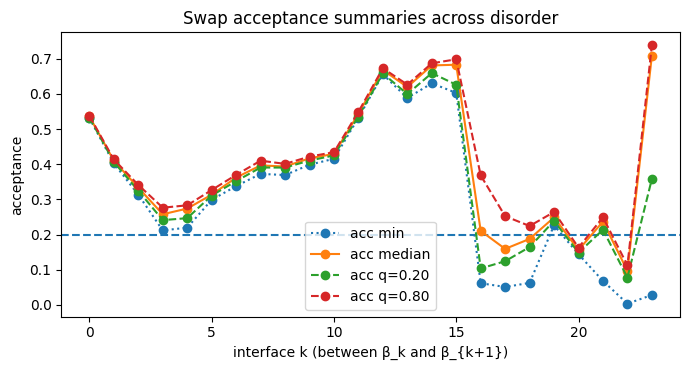

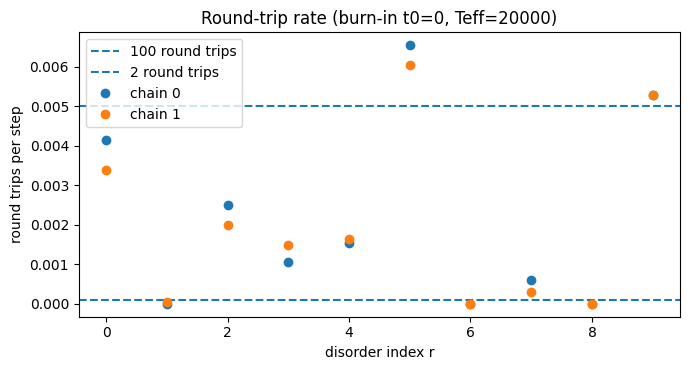

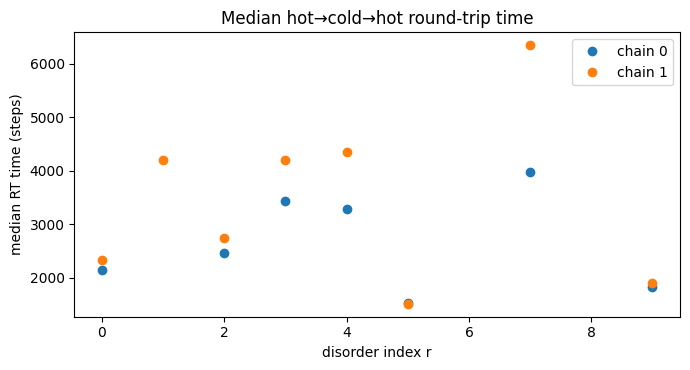

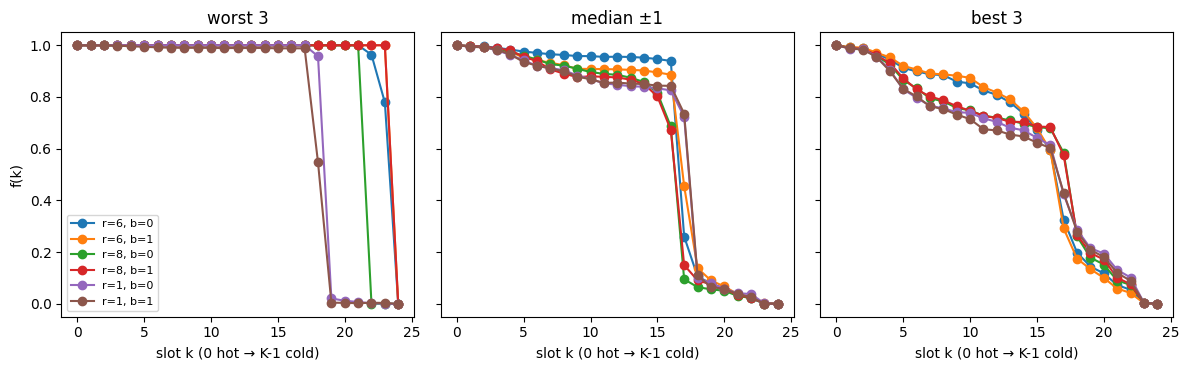

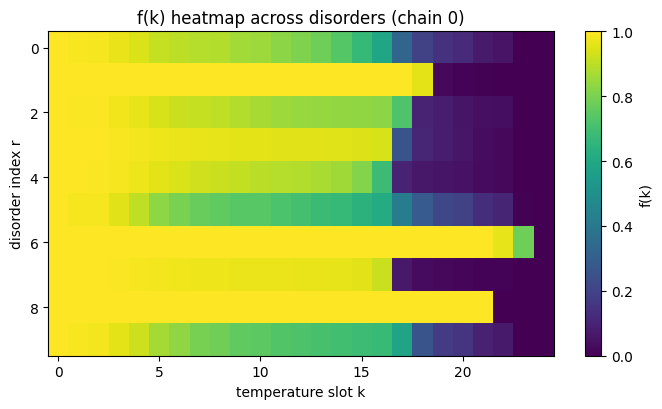

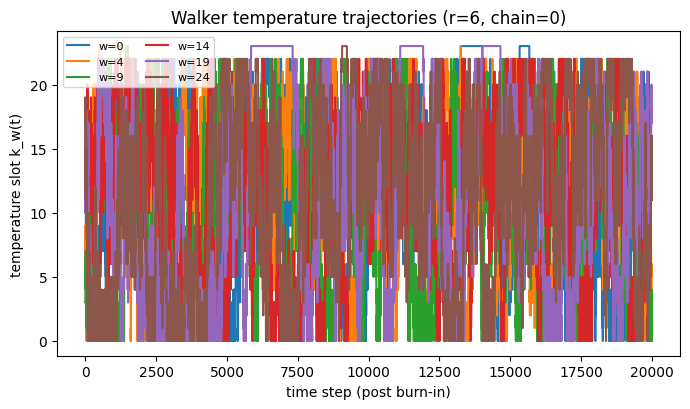

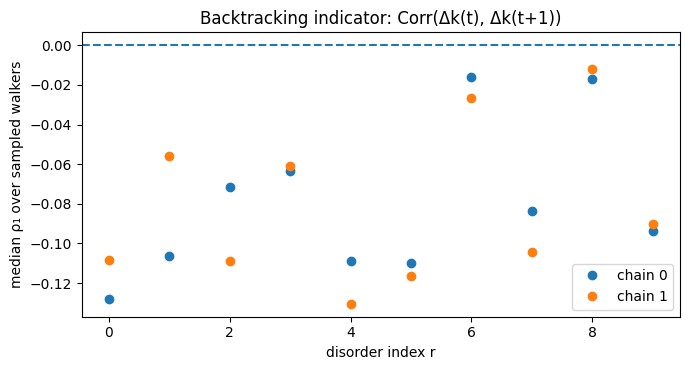

In [18]:
out=pt_diagnostics_report(
    I_ts_stack1,
    betas1,
    acc_stack1)

In [19]:
def refine_ladder(
    sys_template,                  # SysConfig without β fixed
    beta_proposed: np.ndarray,      # 1D array (K,)
    trial,                          # TrialConfig
    R_workers: int, R_total: int,   # pool knobs (disorders)
    A_low=0.20,
    eps=0.01,                      # hysteresis margin
    max_insert=4,
    K_max=64, max_passes=2, verbose=True, start_method="fork"
):
    """
    Refine a proposed ladder by inserting at the WORST interface across disorders:
        acc_min[k] = min_r acc_stack[r,k]
    until acc_min[k] >= A_low - 2*eps for all k, or until limits are reached.

    Returns: (betas, acc_stack, I_ts_stack) from the last evaluation.
    """

    betas = np.asarray(beta_proposed, float).copy()
    inserts = 0

    last_acc_stack = None
    last_I_ts_stack = None

    thr = A_low - 2.0 * eps

    for p in range(1, max_passes + 1):
        sys = replace(sys_template, K=betas.size, β=betas)

        results = pool_orchestrator_stats_1d(
            sys, trial,
            R_workers=R_workers, R_total=R_total,
            start_method=start_method
        )

        acc_stack  = np.stack([r.acc_edge for r in results], axis=0)  # (R_total, K-1)
        I_ts_stack = np.stack([r.I_ts     for r in results], axis=0)  # (R_total, B, T, K)

        last_acc_stack = acc_stack
        last_I_ts_stack = I_ts_stack

        acc_min = acc_stack.min(axis=0)            # (K-1,)
        k_worst = int(np.argmin(acc_min))
        a_worst = float(acc_min[k_worst])

        if verbose:
            print(f"\nrefine pass {p:2d} | K={betas.size:2d} | "
                  f"worst acc_min={a_worst:.4f} at iface {k_worst} | thr={thr:.4f}")

        # success: no single “doomed” interface remains
        if a_worst >= thr:
            if verbose: print("→ refine done (all acc_min above threshold)")
            return betas, acc_stack, I_ts_stack

        # cannot insert further
        if betas.size >= K_max:
            if verbose: print("→ refine stopped (reached K_max)")
            return betas, acc_stack, I_ts_stack

        if inserts >= max_insert:
            if verbose: print("→ refine stopped (reached max_insert)")
            return betas, acc_stack, I_ts_stack

        # insert midpoint at the *current* worst interface
        betas = np.insert(betas, k_worst + 1, 0.5 * (betas[k_worst] + betas[k_worst + 1]))
        inserts += 1
        if verbose: print(f"＋ insert after iface {k_worst}  -> K={betas.size}")

    if verbose: print("→ refine stopped (reached max_passes)")
    return betas, last_acc_stack, last_I_ts_stack

In [22]:
trial1 = TrialConfig_1d(equilibration_time=6000, sweeps_per_sample=50, n_samples=1000)
betas1, acc_stack1, I_ts_stack1 = refine_ladder(
    sys0,                  # SysConfig without β fixed
    betas1,      # 1D array (K,)
    trial1,                          # TrialConfig
    R_workers=10, R_total=10,   # pool knobs (disorders)
    A_low=0.11,
    eps=0.01,                      # hysteresis margin
    max_insert=5,
    K_max=64, max_passes=7, verbose=True, start_method="fork"
)


refine pass  1 | K=25 | worst acc_min=0.1789 at iface 20 | thr=0.0900
→ refine done (all acc_min above threshold)


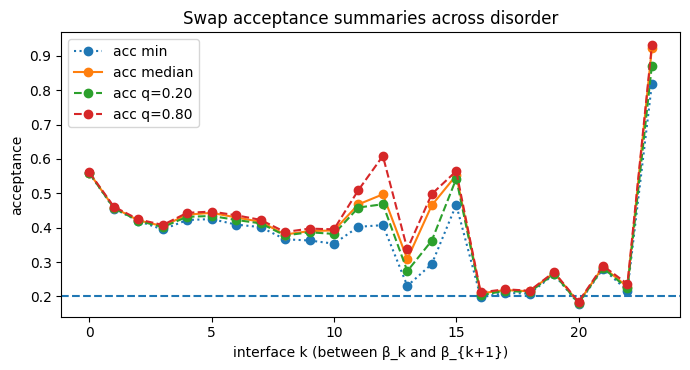

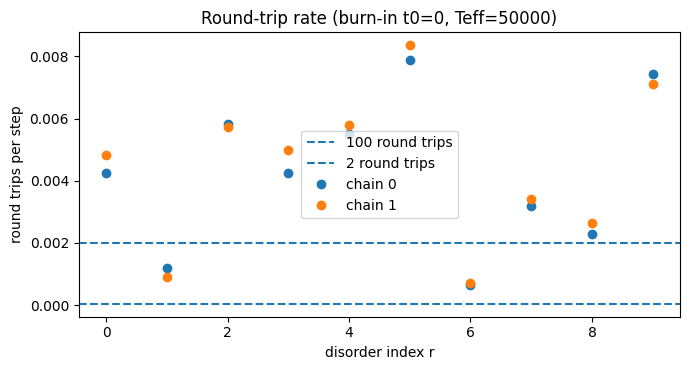

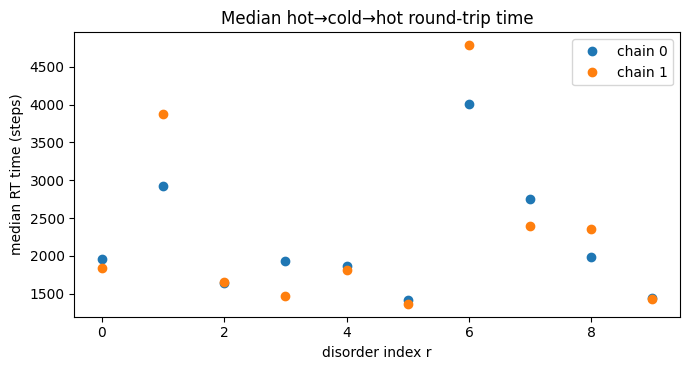

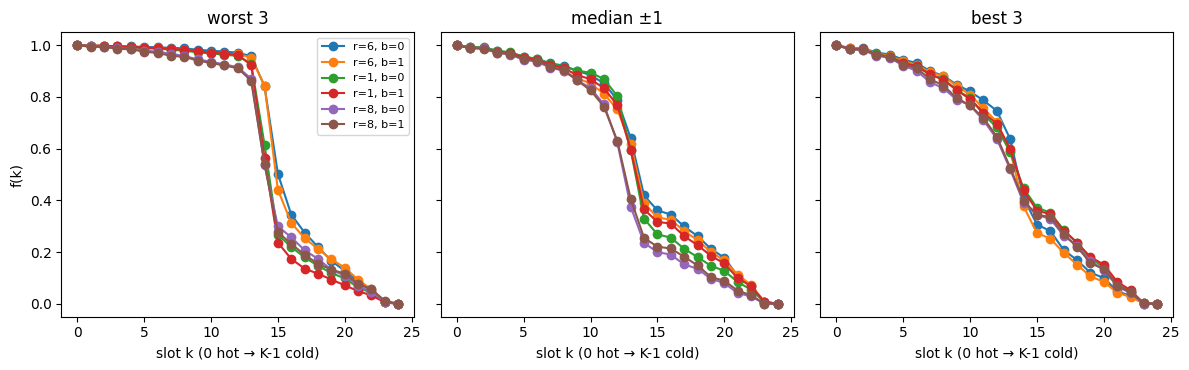

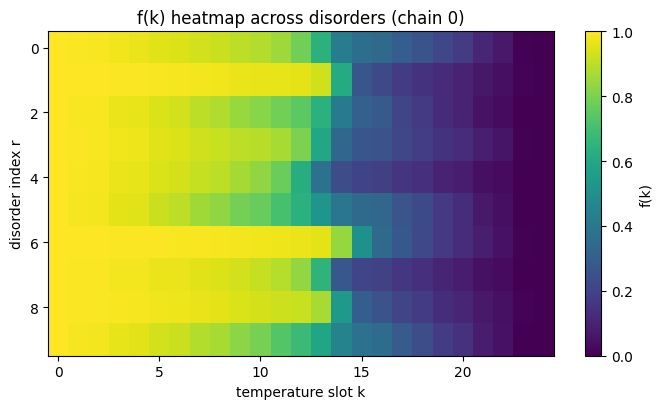

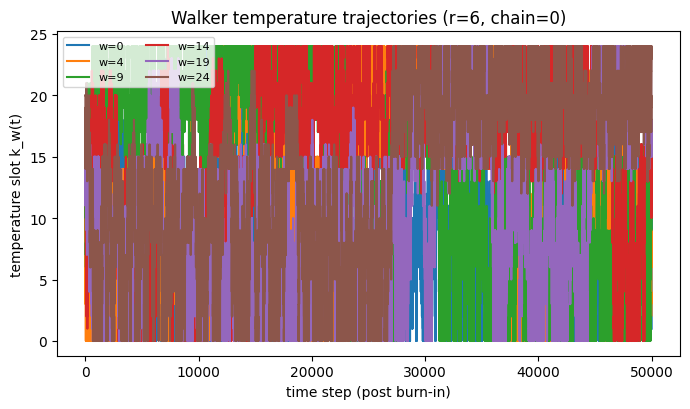

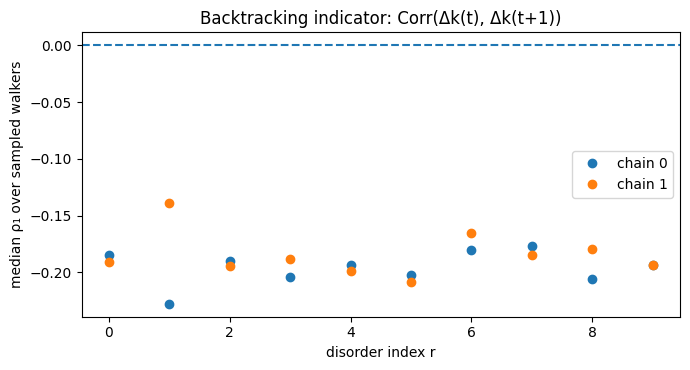

In [24]:
out=pt_diagnostics_report(
    I_ts_stack1,
    betas1,
    acc_stack1)